In [1]:
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import os
cwd = os.getcwd()
if str(cwd) !='drive/My Drive/CZ4041':
    print("Changing directory")
    os.chdir('drive/My Drive/CZ4041')
else:
    print("cwd already set to CZ4041")

Changing directory


In [3]:
%tensorflow_version 1.15

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.15`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [4]:
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing import image
from tqdm import tqdm
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import hamming_loss
from sklearn.metrics import accuracy_score

In [ ]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

In [ ]:
#import dataset
emotions = pd.read_csv("emotions.csv") # 6 labels, 72 features
yeasts = pd.read_csv("yeast.csv")  # 14 labels, 103 features
bookmarks = pd.read_csv("bookmarks.csv") # 208 labels, 2150 features

# 1. Basic Exploratary Data Analysis

In [ ]:
#emotions data set has 72 attributes and 6 labels
emotions.head(5)

,Mean_Acc1298_Mean_Mem40_Centroid,Mean_Acc1298_Mean_Mem40_Rolloff,Mean_Acc1298_Mean_Mem40_Flux,Mean_Acc1298_Mean_Mem40_MFCC_0,Mean_Acc1298_Mean_Mem40_MFCC_1,Mean_Acc1298_Mean_Mem40_MFCC_2,Mean_Acc1298_Mean_Mem40_MFCC_3,Mean_Acc1298_Mean_Mem40_MFCC_4,Mean_Acc1298_Mean_Mem40_MFCC_5,Mean_Acc1298_Mean_Mem40_MFCC_6,Mean_Acc1298_Mean_Mem40_MFCC_7,Mean_Acc1298_Mean_Mem40_MFCC_8,Mean_Acc1298_Mean_Mem40_MFCC_9,Mean_Acc1298_Mean_Mem40_MFCC_10,Mean_Acc1298_Mean_Mem40_MFCC_11,Mean_Acc1298_Mean_Mem40_MFCC_12,Mean_Acc1298_Std_Mem40_Centroid,Mean_Acc1298_Std_Mem40_Rolloff,Mean_Acc1298_Std_Mem40_Flux,Mean_Acc1298_Std_Mem40_MFCC_0,Mean_Acc1298_Std_Mem40_MFCC_1,Mean_Acc1298_Std_Mem40_MFCC_2,Mean_Acc1298_Std_Mem40_MFCC_3,Mean_Acc1298_Std_Mem40_MFCC_4,Mean_Acc1298_Std_Mem40_MFCC_5,Mean_Acc1298_Std_Mem40_MFCC_6,Mean_Acc1298_Std_Mem40_MFCC_7,Mean_Acc1298_Std_Mem40_MFCC_8,Mean_Acc1298_Std_Mem40_MFCC_9,Mean_Acc1298_Std_Mem40_MFCC_10,Mean_Acc1298_Std_Mem40_MFCC_11,Mean_Acc1298_Std_Mem40_MFCC_12,Std_Acc1298_Mean_Mem40_Centroid,Std_Acc1298_Mean_Mem40_Rolloff,Std_Acc1298_Mean_Mem40_Flux,Std_Acc1298_Mean_Mem40_MFCC_0,Std_Acc1298_Mean_Mem40_MFCC_1,Std_Acc1298_Mean_Mem40_MFCC_2,Std_Acc1298_Mean_Mem40_MFCC_3,Std_Acc1298_Mean_Mem40_MFCC_4,Std_Acc1298_Mean_Mem40_MFCC_5,Std_Acc1298_Mean_Mem40_MFCC_6,Std_Acc1298_Mean_Mem40_MFCC_7,Std_Acc1298_Mean_Mem40_MFCC_8,Std_Acc1298_Mean_Mem40_MFCC_9,Std_Acc1298_Mean_Mem40_MFCC_10,Std_Acc1298_Mean_Mem40_MFCC_11,Std_Acc1298_Mean_Mem40_MFCC_12,Std_Acc1298_Std_Mem40_Centroid,Std_Acc1298_Std_Mem40_Rolloff,Std_Acc1298_Std_Mem40_Flux,Std_Acc1298_Std_Mem40_MFCC_0,Std_Acc1298_Std_Mem40_MFCC_1,Std_Acc1298_Std_Mem40_MFCC_2,Std_Acc1298_Std_Mem40_MFCC_3,Std_Acc1298_Std_Mem40_MFCC_4,Std_Acc1298_Std_Mem40_MFCC_5,Std_Acc1298_Std_Mem40_MFCC_6,Std_Acc1298_Std_Mem40_MFCC_7,Std_Acc1298_Std_Mem40_MFCC_8,Std_Acc1298_Std_Mem40_MFCC_9,Std_Acc1298_Std_Mem40_MFCC_10,Std_Acc1298_Std_Mem40_MFCC_11,Std_Acc1298_Std_Mem40_MFCC_12,BH_LowPeakAmp,BH_LowPeakBPM,BH_HighPeakAmp,BH_HighPeakBPM,BH_HighLowRatio,BHSUM1,BHSUM2,BHSUM3,amazed-suprised,happy-pleased,relaxing-calm,quiet-still,sad-lonely,angry-aggresive
0,0.034741,0.089665,0.091225,-73.302422,6.215179,0.615074,2.037160,0.804065,1.301409,0.558576,0.672063,0.783788,0.766640,0.458712,0.530384,0.812429,0.028851,0.129039,0.039614,5.762173,1.636819,1.170034,1.051511,0.764163,0.642705,0.617868,0.510265,0.566213,0.509149,0.477275,0.505073,0.463535,0.013519,0.050591,0.009025,8.156257,1.077167,0.624711,0.810244,0.399568,0.279947,0.314215,0.231439,0.345401,0.285389,0.210613,0.321896,0.290551,0.022774,0.095801,0.015057,4.748694,0.536378,0.296306,0.273210,0.175800,0.105508,0.168246,0.115849,0.136020,0.110514,0.100517,0.118630,0.094923,0.051035,68,0.014937,136,2,0.245457,0.105065,0.405399,0,1,1,0,0,0
1,0.081374,0.272747,0.085733,-62.584437,3.183163,-0.218145,0.163038,0.620251,0.458514,0.041426,0.308287,0.538152,0.594871,0.734332,0.415489,0.761508,0.066288,0.262370,0.034438,3.480874,1.596532,0.943803,0.804444,0.511229,0.498670,0.523039,0.480916,0.488657,0.483166,0.445187,0.415994,0.405593,0.013621,0.073041,0.010094,1.243981,0.829790,0.252972,0.347831,0.205087,0.168601,0.178009,0.144080,0.178703,0.146937,0.125580,0.128202,0.107007,0.020028,0.066940,0.029483,3.963534,0.382360,0.168389,0.117525,0.098341,0.087046,0.057991,0.059393,0.059457,0.053439,0.067684,0.070075,0.041565,0.295031,70,0.276366,140,2,0.343547,0.276366,0.710924,1,0,0,0,0,1
2,0.110545,0.273567,0.084410,-65.235325,2.794964,0.639047,1.281297,0.757896,0.489412,0.627636,0.469322,0.644336,0.441556,0.335964,0.290713,0.158538,0.082743,0.215373,0.035970,4.834742,1.213443,0.864034,0.909222,0.780572,0.550833,0.639740,0.573309,0.526312,0.562622,0.538407,0.492292,0.455562,0.029112,0.070433,0.008525,2.759906,0.592634,0.761852,0.568740,0.589827,0.281181,0.437752,0.479889,0.227320,0.296224,0.273855,0.191804,0.198025,0.038119,0.065427,0.029622,3.371796,0.430373,0.172862,0.177523,0.184333,0.095718,0.139323,0.109279,0.090650,0.117886,0.100852,0.079917,0.085821,0.161574,61,

In [ ]:
emotions.shape

(593, 78)

In [ ]:
#study respective columns and their data types
emotions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593 entries, 0 to 592
Data columns (total 78 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Mean_Acc1298_Mean_Mem40_Centroid  593 non-null    float64
 1    Mean_Acc1298_Mean_Mem40_Rolloff  593 non-null    float64
 2    Mean_Acc1298_Mean_Mem40_Flux     593 non-null    float64
 3    Mean_Acc1298_Mean_Mem40_MFCC_0   593 non-null    float64
 4    Mean_Acc1298_Mean_Mem40_MFCC_1   593 non-null    float64
 5    Mean_Acc1298_Mean_Mem40_MFCC_2   593 non-null    float64
 6    Mean_Acc1298_Mean_Mem40_MFCC_3   593 non-null    float64
 7    Mean_Acc1298_Mean_Mem40_MFCC_4   593 non-null    float64
 8    Mean_Acc1298_Mean_Mem40_MFCC_5   593 non-null    float64
 9    Mean_Acc1298_Mean_Mem40_MFCC_6   593 non-null    float64
 10   Mean_Acc1298_Mean_Mem40_MFCC_7   593 non-null    float64
 11   Mean_Acc1298_Mean_Mem40_MFCC_8   593 non-null    float64
 12   Mean_Ac

It is observed that the target variables are of type int while the attributes are in a mixture of type int and float. It is also noted that none of the variabeles has missing values.

In [ ]:
emotions.describe() 

,Mean_Acc1298_Mean_Mem40_Centroid,Mean_Acc1298_Mean_Mem40_Rolloff,Mean_Acc1298_Mean_Mem40_Flux,Mean_Acc1298_Mean_Mem40_MFCC_0,Mean_Acc1298_Mean_Mem40_MFCC_1,Mean_Acc1298_Mean_Mem40_MFCC_2,Mean_Acc1298_Mean_Mem40_MFCC_3,Mean_Acc1298_Mean_Mem40_MFCC_4,Mean_Acc1298_Mean_Mem40_MFCC_5,Mean_Acc1298_Mean_Mem40_MFCC_6,Mean_Acc1298_Mean_Mem40_MFCC_7,Mean_Acc1298_Mean_Mem40_MFCC_8,Mean_Acc1298_Mean_Mem40_MFCC_9,Mean_Acc1298_Mean_Mem40_MFCC_10,Mean_Acc1298_Mean_Mem40_MFCC_11,Mean_Acc1298_Mean_Mem40_MFCC_12,Mean_Acc1298_Std_Mem40_Centroid,Mean_Acc1298_Std_Mem40_Rolloff,Mean_Acc1298_Std_Mem40_Flux,Mean_Acc1298_Std_Mem40_MFCC_0,Mean_Acc1298_Std_Mem40_MFCC_1,Mean_Acc1298_Std_Mem40_MFCC_2,Mean_Acc1298_Std_Mem40_MFCC_3,Mean_Acc1298_Std_Mem40_MFCC_4,Mean_Acc1298_Std_Mem40_MFCC_5,Mean_Acc1298_Std_Mem40_MFCC_6,Mean_Acc1298_Std_Mem40_MFCC_7,Mean_Acc1298_Std_Mem40_MFCC_8,Mean_Acc1298_Std_Mem40_MFCC_9,Mean_Acc1298_Std_Mem40_MFCC_10,Mean_Acc1298_Std_Mem40_MFCC_11,Mean_Acc1298_Std_Mem40_MFCC_12,Std_Acc1298_Mean_Mem40_Centroid,Std_Acc1298_Mean_Mem40_Rolloff,Std_Acc1298_Mean_Mem40_Flux,Std_Acc1298_Mean_Mem40_MFCC_0,Std_Acc1298_Mean_Mem40_MFCC_1,Std_Acc1298_Mean_Mem40_MFCC_2,Std_Acc1298_Mean_Mem40_MFCC_3,Std_Acc1298_Mean_Mem40_MFCC_4,Std_Acc1298_Mean_Mem40_MFCC_5,Std_Acc1298_Mean_Mem40_MFCC_6,Std_Acc1298_Mean_Mem40_MFCC_7,Std_Acc1298_Mean_Mem40_MFCC_8,Std_Acc1298_Mean_Mem40_MFCC_9,Std_Acc1298_Mean_Mem40_MFCC_10,Std_Acc1298_Mean_Mem40_MFCC_11,Std_Acc1298_Mean_Mem40_MFCC_12,Std_Acc1298_Std_Mem40_Centroid,Std_Acc1298_Std_Mem40_Rolloff,Std_Acc1298_Std_Mem40_Flux,Std_Acc1298_Std_Mem40_MFCC_0,Std_Acc1298_Std_Mem40_MFCC_1,Std_Acc1298_Std_Mem40_MFCC_2,Std_Acc1298_Std_Mem40_MFCC_3,Std_Acc1298_Std_Mem40_MFCC_4,Std_Acc1298_Std_Mem40_MFCC_5,Std_Acc1298_Std_Mem40_MFCC_6,Std_Acc1298_Std_Mem40_MFCC_7,Std_Acc1298_Std_Mem40_MFCC_8,Std_Acc1298_Std_Mem40_MFCC_9,Std_Acc1298_Std_Mem40_MFCC_10,Std_Acc1298_Std_Mem40_MFCC_11,Std_Acc1298_Std_Mem40_MFCC_12,BH_LowPeakAmp,BH_LowPeakBPM,BH_HighPeakAmp,BH_HighPeakBPM,BH_HighLowRatio,BHSUM1,BHSUM2,BHSUM3,amazed-suprised,happy-pleased,relaxing-calm,quiet-still,sad-lonely,angry-aggresive
count,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000
mean,0.069309,0.195399,0.085695,-72.998228,4.979178,0.602395,1.694625,0.634156,0.833964,0.508060,0.539452,0.471183,0.509122,0.477661,0.439237,0.445350,0.045755,0.157495,0.035775,4.574782,1.298807,0.941415,0.778116,0.650144,0.577431,0.552497,0.536358,0.518485,0.509343,0.492222,0.483663,0.469662,0.023932,0.063271,0.008137,3.641956,0.858002,0.623887,0.499193,0.385509,0.331884,0.313391,0.307803,0.304763,0.298987,0.287374,0.279034,0.271922,0.028901,0.066452,0.029527,4.147196,0.408222,0.239404,0.198588,0.151062,0.123111,0.115476,0.114181,0.113154,0.113794,0.109990,0.109876,0.107114,0.230008,74.456998,0.247854,155.215852,2.099494,0.412940,0.354901,0.959906,0.291737,0.279933,0.445194,0.249578,0.283305,0.318718
std,0.031293,0.117605,0.009260,7.580804,2.071792,1.017603,0.606581,0.448746,0.368312,0.303277,0.304705,0.282673,0.244190,0.219967,0.221101,0.201583,0.029710,0.108850,0.008561,1.560977,0.403095,0.270601,0.213410,0.154363,0.107429,0.094156,0.090469,0.083432,0.081292,0.072786,0.074544,0.077775,0.010763,0.031272

Large difference between 75 percentile and the max value in each column, which indicates that there are siginificant outliers within the datasets

## 1.1 Understanding outliers

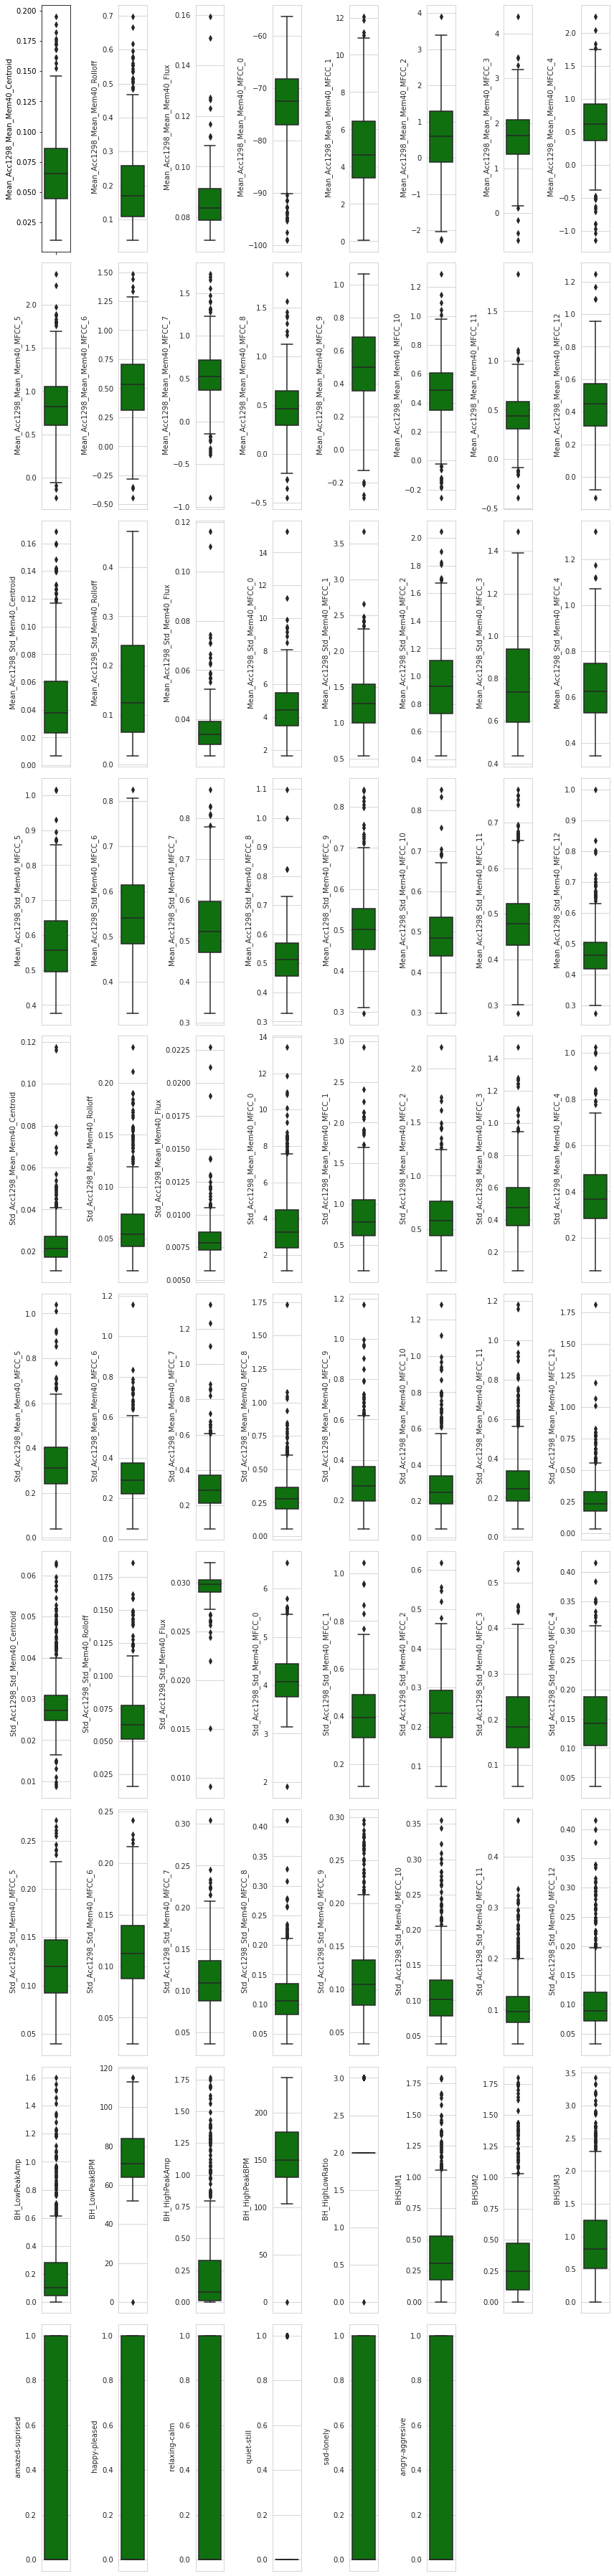

In [ ]:
l = emotions.columns.values
number_of_columns=8
number_of_rows = len(l)-1/number_of_columns
plt.figure(figsize=(number_of_columns*1.5,5*number_of_rows))
for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.set_style('whitegrid')
    sns.boxplot(emotions[l[i]],color='green',orient='v')
    plt.tight_layout()

It can be observed that most of the features columns have extreme stretch of outliers and thus data normalization is required before performing respective classification task.

## 1.2 Observing distribution Skewness of dataset

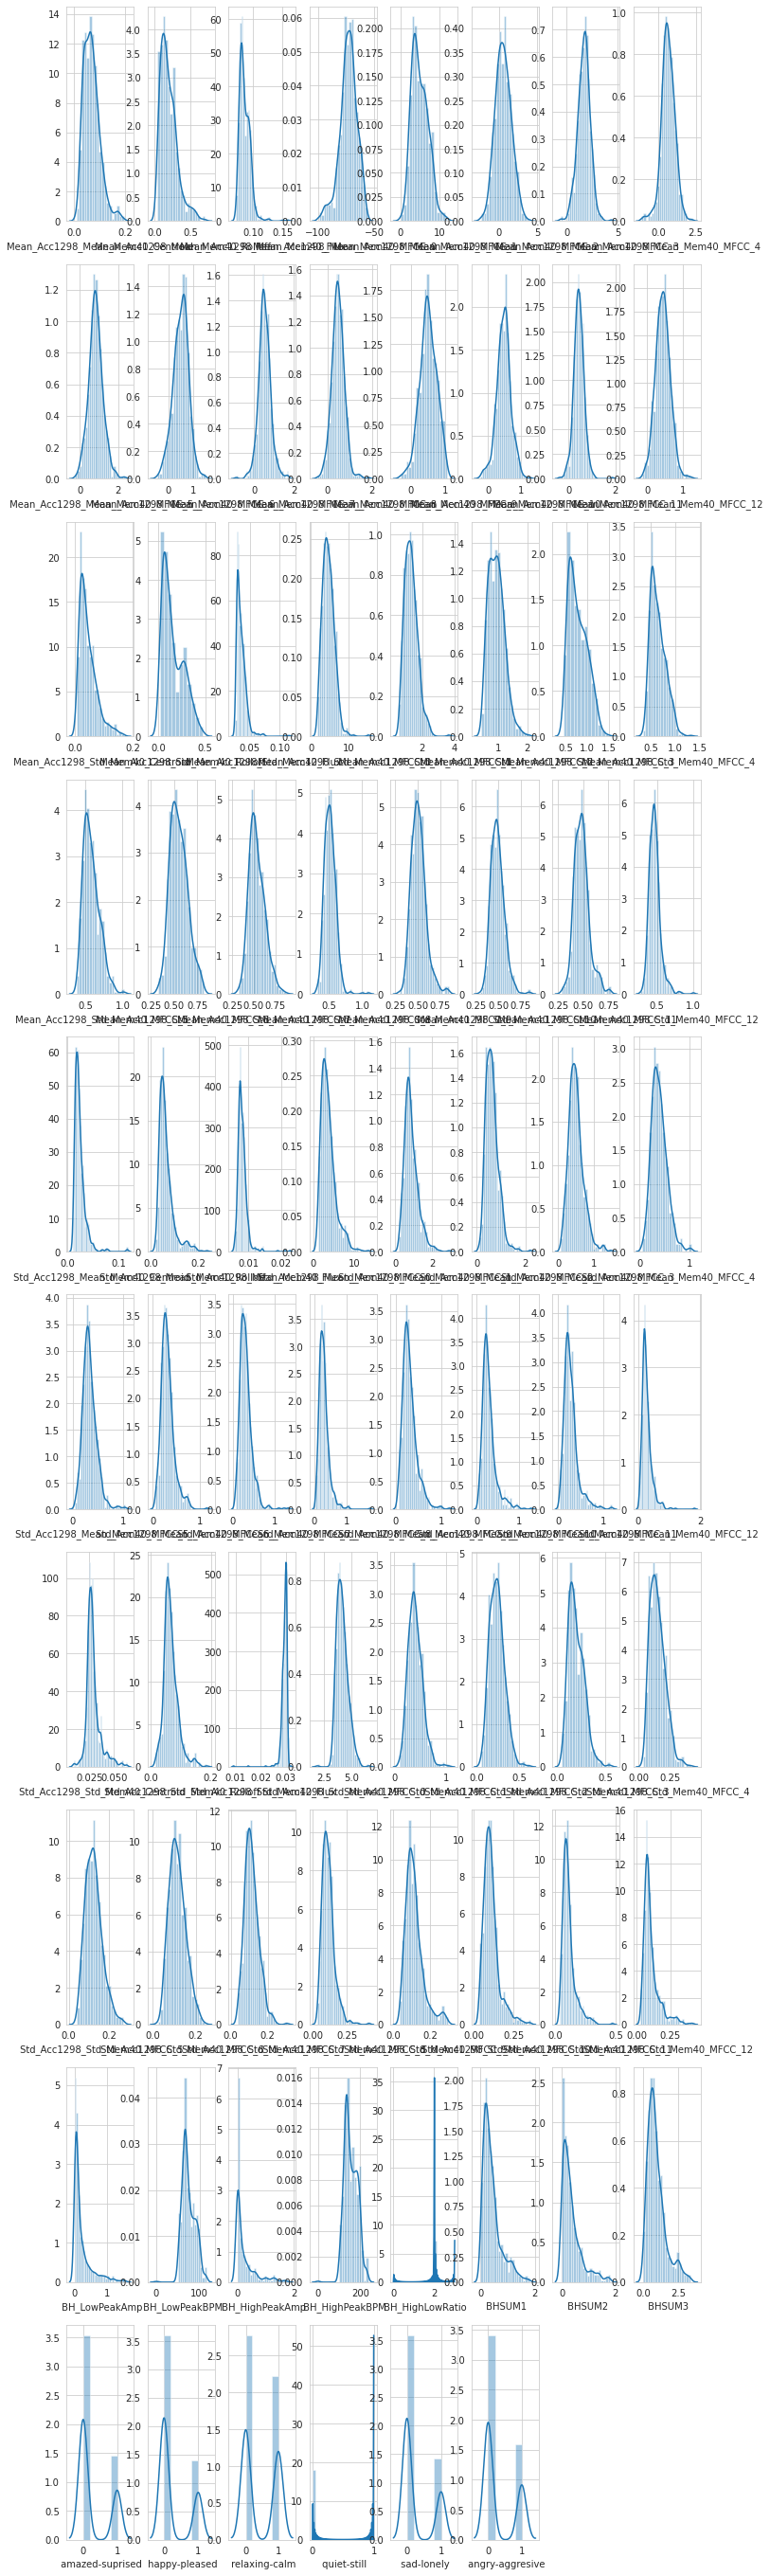

In [ ]:
plt.figure(figsize=(1.5*number_of_columns,5*number_of_rows))
for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.distplot(emotions[l[i]],kde=True) 

1. Most variables are not evenly distributed.
2. Dataset seems to be unbalanced as there are not much samples that correspond to 'quiet-still' label.

# 2. Correlation analysis

## 2.1 basic correlation

In [ ]:
emotions.corr()

,Mean_Acc1298_Mean_Mem40_Centroid,Mean_Acc1298_Mean_Mem40_Rolloff,Mean_Acc1298_Mean_Mem40_Flux,Mean_Acc1298_Mean_Mem40_MFCC_0,Mean_Acc1298_Mean_Mem40_MFCC_1,Mean_Acc1298_Mean_Mem40_MFCC_2,Mean_Acc1298_Mean_Mem40_MFCC_3,Mean_Acc1298_Mean_Mem40_MFCC_4,Mean_Acc1298_Mean_Mem40_MFCC_5,Mean_Acc1298_Mean_Mem40_MFCC_6,Mean_Acc1298_Mean_Mem40_MFCC_7,Mean_Acc1298_Mean_Mem40_MFCC_8,Mean_Acc1298_Mean_Mem40_MFCC_9,Mean_Acc1298_Mean_Mem40_MFCC_10,Mean_Acc1298_Mean_Mem40_MFCC_11,Mean_Acc1298_Mean_Mem40_MFCC_12,Mean_Acc1298_Std_Mem40_Centroid,Mean_Acc1298_Std_Mem40_Rolloff,Mean_Acc1298_Std_Mem40_Flux,Mean_Acc1298_Std_Mem40_MFCC_0,Mean_Acc1298_Std_Mem40_MFCC_1,Mean_Acc1298_Std_Mem40_MFCC_2,Mean_Acc1298_Std_Mem40_MFCC_3,Mean_Acc1298_Std_Mem40_MFCC_4,Mean_Acc1298_Std_Mem40_MFCC_5,Mean_Acc1298_Std_Mem40_MFCC_6,Mean_Acc1298_Std_Mem40_MFCC_7,Mean_Acc1298_Std_Mem40_MFCC_8,Mean_Acc1298_Std_Mem40_MFCC_9,Mean_Acc1298_Std_Mem40_MFCC_10,Mean_Acc1298_Std_Mem40_MFCC_11,Mean_Acc1298_Std_Mem40_MFCC_12,Std_Acc1298_Mean_Mem40_Centroid,Std_Acc1298_Mean_Mem40_Rolloff,Std_Acc1298_Mean_Mem40_Flux,Std_Acc1298_Mean_Mem40_MFCC_0,Std_Acc1298_Mean_Mem40_MFCC_1,Std_Acc1298_Mean_Mem40_MFCC_2,Std_Acc1298_Mean_Mem40_MFCC_3,Std_Acc1298_Mean_Mem40_MFCC_4,Std_Acc1298_Mean_Mem40_MFCC_5,Std_Acc1298_Mean_Mem40_MFCC_6,Std_Acc1298_Mean_Mem40_MFCC_7,Std_Acc1298_Mean_Mem40_MFCC_8,Std_Acc1298_Mean_Mem40_MFCC_9,Std_Acc1298_Mean_Mem40_MFCC_10,Std_Acc1298_Mean_Mem40_MFCC_11,Std_Acc1298_Mean_Mem40_MFCC_12,Std_Acc1298_Std_Mem40_Centroid,Std_Acc1298_Std_Mem40_Rolloff,Std_Acc1298_Std_Mem40_Flux,Std_Acc1298_Std_Mem40_MFCC_0,Std_Acc1298_Std_Mem40_MFCC_1,Std_Acc1298_Std_Mem40_MFCC_2,Std_Acc1298_Std_Mem40_MFCC_3,Std_Acc1298_Std_Mem40_MFCC_4,Std_Acc1298_Std_Mem40_MFCC_5,Std_Acc1298_Std_Mem40_MFCC_6,Std_Acc1298_Std_Mem40_MFCC_7,Std_Acc1298_Std_Mem40_MFCC_8,Std_Acc1298_Std_Mem40_MFCC_9,Std_Acc1298_Std_Mem40_MFCC_10,Std_Acc1298_Std_Mem40_MFCC_11,Std_Acc1298_Std_Mem40_MFCC_12,BH_LowPeakAmp,BH_LowPeakBPM,BH_HighPeakAmp,BH_HighPeakBPM,BH_HighLowRatio,BHSUM1,BHSUM2,BHSUM3,amazed-suprised,happy-pleased,relaxing-calm,quiet-still,sad-lonely,angry-aggresive
Mean_Acc1298_Mean_Mem40_Centroid,1.000000,0.632846,0.164513,0.369808,-0.642412,-0.211317,-0.293023,-0.203168,-0.274803,-0.070938,-0.050303,0.106875,-0.027120,0.060280,0.075249,-0.002623,0.726390,0.233859,-0.017517,0.006410,-0.005880,0.120326,0.156554,0.145269,0.156510,0.158141,0.135385,0.137241,0.130419,0.121749,0.110312,0.073815,0.507491,0.049425,-0.058552,-0.267902,-0.256984,-0.130775,-0.134602,-0.211151,-0.154525,-0.151453,-0.162657,-0.129406,-0.134381,-0.134948,-0.184169,-0.182276,-0.076127,-0.380931,0.043399,-0.240788,-0.285766,-0.149208,-0.137191,-0.142272,-0.191834,-0.226607,-0.209454,-0.167661,-0.145758,-0.147322,-0.150521,-0.131741,0.397941,-0.117797,0.376457,-0.133337,-0.042174,0.343127,0.399403,0.414809,0.345763,0.108973,-0.305083,-0.424649,-0.335437,0.267874
Mean_Acc1298_Mean_Mem40_Rolloff,0.632846,1.000000,0.578299,0.291996,-0.706719,0.068122,-0.322313,0.064595,-0.205271,0.114298,0.039633,0.258674,0.090877,0.140807,0.123487,0.121092,0.752729,0.809104,0.476947,0.378774,0.312443,0.349946,0.280552,0.241402,0.190011,0.189095,0.120259,0.031401,0.019037,-0.037809,-0.070476,-0.062262,0.408624,0.446865,0.152393,-0.321233,-0.340561,-0.205178,-0.241834,-0.328334,-0.360927,-0.358078,-0.367308,-0.369626,-0.379842,-0.381872,-0.419492,-0.405488,-0.008222,-0.246209,-0.248409,-0.400855,-0.357180,-0.185817,-0.164300,-0.155349,-0.269479,-0.269663,-0.296667,-0.326589,-0.322976,-0.334883,-0.321985,-0.289986,0.590386,-0.210564,0.539803,-0.226174,-0.041721,0.465338,0.512114,0.506630,0.339501,0.031251,-0.348233,-0.491562,-0.380406,0.375731
Mean_Acc1298_Mean_Mem40_Flux,0.164513,0.578299,1.000000,0.057385,-0.362375,0.150480,-0.097567,0.181392,-0.038637,0.205862,0.158235,0.204782,0.087202,0.115501,0.124817,0.152076,0.569908,0.731653,0.918164,0.767852,0.719133,0.644317,0.552559,0.530501,0.488974,0.431579,0.364350,0.251058,0.197160,0.104767,0.071135,0.054762,0.241115,

In [ ]:
#train test split
from sklearn.model_selection import train_test_split
train, test = train_test_split(emotions, random_state=42, test_size=0.20, shuffle=True)
x_train = train.iloc[:,0:72]
y_train = train.iloc[:,-6:]
x_test = test.iloc[:,0:72]
y_test = test.iloc[:,-6:]

In [ ]:
#feature scaling
from sklearn.preprocessing import MinMaxScaler
x_scaler = MinMaxScaler(feature_range=(0,1))
x_scaled_train =  np.float32(x_scaler.fit_transform(x_train))
x_scaled_test = np.float32(x_scaler.fit_transform(x_test))
print("x_scaled_train shape: {}, x_scaled_test shape: {}".format(x_scaled_train.shape,x_scaled_test.shape))
print("x_scaled_train type: {}, x_scaled_test type: {}".format(type(x_scaled_train),type(x_scaled_test)))

x_scaled_train shape: (474, 72), x_scaled_test shape: (119, 72)
x_scaled_train type: <class 'numpy.ndarray'>, x_scaled_test type: <class 'numpy.ndarray'>


## 2.2 Identifying label correlation

### 2.2.1 Chi square table test

In [ ]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 474 entries, 245 to 102
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0    amazed-suprised  474 non-null    int64
 1    happy-pleased    474 non-null    int64
 2    relaxing-calm    474 non-null    int64
 3    quiet-still      474 non-null    int64
 4    sad-lonely       474 non-null    int64
 5    angry-aggresive  474 non-null    int64
dtypes: int64(6)
memory usage: 25.9 KB


In [ ]:
from scipy.stats import chi2_contingency
col1 = y_train.iloc[:,0]
col2 = y_train.iloc[:,4]
table = pd.crosstab(col1,col2)
print(table)
chi2, p , dof, expected = chi2_contingency(table.values)
print("Chi square staistics: {:0.3f}, p_value: {:0.30f}".format(chi2,p))

 sad-lonely         0    1
 amazed-suprised          
0                 209  128
1                 128    9
Chi square staistics: 45.257, p_value: 0.000000000017283781632733888532


In [ ]:
label_names = y_train.columns.values
print(label_names)

[' amazed-suprised' ' happy-pleased' ' relaxing-calm' ' quiet-still'
 ' sad-lonely' ' angry-aggresive']


In [ ]:
result = np.ndarray(shape=(6,6), dtype=float)
print(result)

[[0.00e+000 4.94e-324 9.88e-324 1.48e-323 1.98e-323 2.47e-323]
 [2.96e-323 3.46e-323 3.95e-323 4.45e-323 4.94e-323 5.43e-323]
 [5.93e-323 6.42e-323 6.92e-323 7.41e-323 7.91e-323 8.40e-323]
 [3.01e-322 3.06e-322 3.11e-322 3.16e-322 3.21e-322 3.26e-322]
 [3.31e-322 3.36e-322 3.41e-322 3.46e-322 3.51e-322 3.56e-322]
 [3.61e-322 3.66e-322 3.71e-322 3.75e-322 3.80e-322 3.85e-322]]


In [ ]:
label_names = y_train.columns.values
p_value_list = []
for i in range(6):
  col1 = y_train.iloc[:,i]
  for j in range(6):
    col2 = y_train.iloc[:,j]
    table = pd.crosstab(col1,col2)
    chi2, p , dof, expected = chi2_contingency(table.values)
    result[i][j] = p
    #print("({} - {}) p_value: {}".format(label_names[i],label_names[j],p))   
print(result)

[[4.91566398e-104 2.53897845e-001 7.58607713e-025 2.55535034e-016
  1.72837816e-011 5.12186566e-009]
 [2.53897845e-001 5.13495450e-104 2.01515185e-002 1.58189434e-010
  8.01631303e-017 3.18879629e-013]
 [7.58607713e-025 2.01515185e-002 3.26957031e-104 1.23802402e-012
  3.55758099e-004 2.47398583e-031]
 [2.55535034e-016 1.58189434e-010 1.23802402e-012 5.66251922e-104
  7.19066930e-030 2.08953366e-016]
 [1.72837816e-011 8.01631303e-017 3.55758099e-004 7.19066930e-030
  4.91566398e-104 3.26275778e-008]
 [5.12186566e-009 3.18879629e-013 2.47398583e-031 2.08953366e-016
  3.26275778e-008 4.42772624e-104]]


In [ ]:
result_df = pd.DataFrame(data=result)
result_df.columns = label_names
result_df.index = label_names
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
print(result_df)

                   amazed-suprised   happy-pleased   relaxing-calm    quiet-still     sad-lonely   angry-aggresive
 amazed-suprised     4.915664e-104    2.538978e-01    7.586077e-25   2.555350e-16   1.728378e-11      5.121866e-09
 happy-pleased        2.538978e-01   5.134955e-104    2.015152e-02   1.581894e-10   8.016313e-17      3.188796e-13
 relaxing-calm        7.586077e-25    2.015152e-02   3.269570e-104   1.238024e-12   3.557581e-04      2.473986e-31
 quiet-still          2.555350e-16    1.581894e-10    1.238024e-12  5.662519e-104   7.190669e-30      2.089534e-16
 sad-lonely           1.728378e-11    8.016313e-17    3.557581e-04   7.190669e-30  4.915664e-104      3.262758e-08
 angry-aggresive      5.121866e-09    3.188796e-13    2.473986e-31   2.089534e-16   3.262758e-08     4.427726e-104


In [ ]:
corr_table = np.ndarray(shape= (6,6), dtype = np.int)
for i in range(6):
  for j in range(6):
     corr_table[i][j] = result[i][j]<0.05
print(corr_table)

[[1 0 1 1 1 1]
 [0 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]]


In [ ]:
df = pd.DataFrame(data=corr_table)
df.columns = label_names
df.index = label_names
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
print(df)

                   amazed-suprised   happy-pleased   relaxing-calm   quiet-still   sad-lonely   angry-aggresive
 amazed-suprised                 1               0               1             1            1                 1
 happy-pleased                   0               1               1             1            1                 1
 relaxing-calm                   1               1               1             1            1                 1
 quiet-still                     1               1               1             1            1                 1
 sad-lonely                      1               1               1             1            1                 1
 angry-aggresive                 1               1               1             1            1                 1
